In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from rdkit import Chem
from rdkit.Chem import AllChem
from tdc import Oracle

In [148]:
# Load data and Oracle
oracle = Oracle(name='DRD2')
training_data = pd.read_csv("../data/drd2_final_train_small.csv")
testing_data = pd.read_csv("../data/drd2_final_test_small.csv")
smiles_train = training_data['smiles'].tolist()
smiles_test = testing_data['smiles'].tolist()
label_proba_train = [oracle(smiles) for smiles in smiles_train]
label_proba_test = [oracle(smiles) for smiles in smiles_test]
print(f"Training data len: {len(smiles_train)}")
print(f"Testing data len: {len(smiles_test)}")

Found local copy...


Training data len: 200
Testing data len: 200


### Computing morgan fingerprints

In [149]:
def compute_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    else:
        return np.zeros((2048,), dtype=int)

features_train = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_train])
features_test = torch.tensor([compute_fingerprints(smiles) for smiles in smiles_test])
label_proba_train = torch.tensor(label_proba_train)
label_proba_test = torch.tensor(label_proba_test)
label_binary_train = torch.tensor(training_data["label"].to_numpy())
label_binary_test = torch.tensor(testing_data["label"].to_numpy())

print("features_train shape: ", features_train.shape)
print("label_proba_train shape: ", label_proba_train.shape)
print("label_binary_train shape: ", label_binary_train.shape)

print("features_test shape: ", features_test.shape)
print("label_proba_test shape: ", label_proba_test.shape)
print("label_binary_test shape: ", label_binary_test.shape)

features_train shape:  torch.Size([200, 2048])
label_proba_train shape:  torch.Size([200])
label_binary_train shape:  torch.Size([200])
features_test shape:  torch.Size([200, 2048])
label_proba_test shape:  torch.Size([200])
label_binary_test shape:  torch.Size([200])


In [150]:
# Now we need to save them 

small_drd2_training_data = pd.DataFrame()
small_drd2_training_data['smiles'] = smiles_train
small_drd2_training_data['label_proba'] = label_proba_train
small_drd2_training_data['label_binary'] = label_binary_train

small_drd2_training_data.to_csv("small_drd2_training_data.csv", index=False)

small_drd2_testing_data = pd.DataFrame()
small_drd2_testing_data['smiles'] = smiles_test
small_drd2_testing_data['label_proba'] = label_proba_test
small_drd2_testing_data['label_binary'] = label_binary_test

small_drd2_testing_data.to_csv("small_drd2_testing_data.csv", index=False)

### Use proba label to train. Probably a correct approach

In [151]:
from score_regression import ScoreRegressionModel
    
# Training the model
model = ScoreRegressionModel(feature_dim=2048)

# When using Binary Cross-Entropy Loss (BCELoss) in neural networks, the input expected by the 
# loss function is a list of probabilities, not binary values (0 or 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)

# Create torch data loader

from torch.utils.data import TensorDataset, DataLoader

# Assuming X_train and y_train are numpy arrays, convert them to PyTorch tensors
features_train_tensor = torch.tensor(features_train).float()  # Ensure dtype is float32 for features
label_proba_train_tensor = torch.tensor(label_proba_train).float()  # Ensure dtype is float32 if regression, or long if classification
features_test_tensor = torch.tensor(features_test).float()  # Ensure dtype is float32 for features
label_proba_test_tensor = torch.tensor(label_proba_test).float()  # Ensure dtype is float32 if regression, or long if classification

# Create a TensorDataset
train_dataset = TensorDataset(features_train_tensor, label_proba_train_tensor)
test_dataset = TensorDataset(features_test_tensor, label_proba_test_tensor)

# Create a DataLoader
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

def train(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for features, label_binary in train_loader:
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, label_binary.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch+1) % 5 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss / len(features)}')

train(model, train_loader)

# save state dict
torch.save(model.state_dict(), "score_regression_model.pth")

print("Model trained and saved")


Epoch 5, Loss: 0.6072049662470818
Model trained and saved


### Perform prediction on the testing dataset

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(label, predictions):
    """
    Compute classification metrics: accuracy, precision, recall, F1 score, and MCC.
    
    Args:
    label (list[int]): True binary label.
    predictions (list[int]): Predicted binary label.

    Returns:
    dict: A dictionary containing the computed metrics.
    """
    accuracy = accuracy_score(label, predictions)
    precision = precision_score(label, predictions)
    recall = recall_score(label, predictions)
    f1 = f1_score(label, predictions)
    mcc = matthews_corrcoef(label, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'MCC': mcc
    }

In [153]:
# Initialize the model
model = ScoreRegressionModel(feature_dim=2048)
# Load the state dict
model.load_state_dict(torch.load("score_regression_model.pth"))

from scripts.acquisition import predict_proba_from_model

pred_label_proba_test = predict_proba_from_model(feedback_type = "scoring", 
                                                 feedback_model = model, 
                                                 smiles=smiles_test)

pred_label_binary_test = (torch.tensor(pred_label_proba_test) > 0.5).int().tolist()

metrics = compute_metrics(label_binary_test, pred_label_binary_test)

print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1:", metrics['F1'])
print("MCC:", metrics['MCC'])

Batch 1 processed
Accuracy: 0.5
Precision: 0.5
Recall: 1.0
F1: 0.6666666666666666
MCC: 0.0


### Plot the roc curve

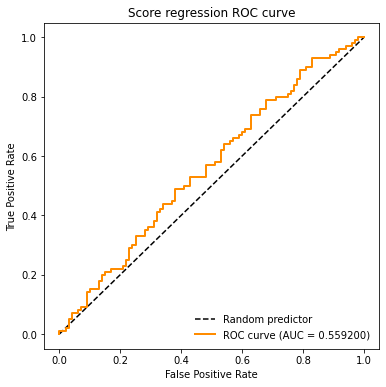

In [154]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_binary_test, pred_label_proba_test, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))

# draw a diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Random predictor")

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.6f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Score regression ROC curve')

plt.legend(loc="lower right", frameon=False)

#### The model performs weakly, which means that we can now use this model as a human component for HITL. Ideally, the initial model should be no better than random guess